Let's now switch to Class Incremental Learning. In this case, we do not know the task labels associated with data points. We do not know to which experience data points belong during the inference phase. We will see that this case is more difficult than Task Incremental Learning, even if the data stream is the same.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
N_EXP = 5
TRAIN_MB_SIZE = 128
TRAIN_EPOCHS = 15
EVAL_MB_SIZE = 128
folder = "/content/drive/MyDrive/Colab Notebooks/CL/perf/03_class_incremental"
# the folder in Drive in which store the performance
perf = {} # a dictionary that will contain the performance for all the strategies

In [ ]:
! pip install avalanche-lib==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 894.6/894.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.4/532.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.2/508.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 904.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 898.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.6 MB/s eta 0:00:

In [ ]:
from avalanche.benchmarks.classic import SplitCIFAR10
from avalanche.models import SimpleCNN, SimpleMLP
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics,\
    forward_transfer_metrics,bwt_metrics,\
    ram_usage_metrics, timing_metrics, EpochAccuracy
from torch.nn import CrossEntropyLoss
from avalanche.training.plugins import EarlyStoppingPlugin
from torch.optim import SGD
import torch

In [ ]:
import torch

In [ ]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# function that creates the base model
def build_model():
  # return SimpleCNN(num_classes=10)
  return SimpleMLP(num_classes=10,input_size=32*32*3, hidden_size=512)

# function that creates the evaluation plugin
# it is used to define the metrics to compute
def build_eval_plugin():
  return EvaluationPlugin(
      accuracy_metrics(experience=True, stream=True),
      # compute the accuracy on each experience's test set and on on the entire
      # test stream
      bwt_metrics(experience=True,stream=True),
      # the same for the FINAL backward transfer metric
      forward_transfer_metrics(experience=True,stream=True),
      # the same for the forward transfer metric
      timing_metrics(epoch=True),
      # compute the time metrics during the training phase
      ram_usage_metrics(epoch=True, every=0.001),
      # compute the max ram usage metrics during the training phase,
      # update it every 0.001 seconds
      loggers=[]
      # we do not use loggers, we save the results using the dictionary returned
      # by the train method of the strategy
  )

# function that builds the optimizer given the model
def build_optimizer(model):
  return SGD(model.parameters(), lr=0.001, momentum=0.9)

# function that creates the loss function
def build_criterion():
  return CrossEntropyLoss()

In [ ]:
# utility functions to take the correct keys in the metrics dictionary
def acc_exp_str(exp):
  exp = "{:03d}".format(exp)
  return f'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{exp}'

def avg_acc_str(n_exp):
  exp = "{:03d}".format(n_exp-1)
  return f'Top1_Acc_Stream/eval_phase/test_stream/Task000'

def fwt_exp_str(exp):
  exp = "{:03d}".format(exp)
  return f'ExperienceForwardTransfer/eval_phase/test_stream/Task000/Exp{exp}'

def fwt_final_str():
  return "StreamForwardTransfer/eval_phase/test_stream"

def bwt_exp_str(exp):
  exp = "{:03d}".format(exp)
  return f'ExperienceBWT/eval_phase/test_stream/Task000/Exp{exp}'

def bwt_final_str():
  return 'StreamBWT/eval_phase/test_stream'

def memory_final_str():
  return f'MaxRAMUsage_Epoch/train_phase/train_stream/Task000'

def time_final_str():
  return f'Time_Epoch/train_phase/train_stream/Task000'

In [ ]:
def build_perf(res):
  perf = {}
  perf["accuracies"] = [[r[acc_exp_str(exp)] for exp in range(N_EXP)] for r in res]
  perf["average_accuracy"] = res[-1][avg_acc_str(N_EXP)] #final accuracy
  perf["a_metric"] = np.sum([perf["accuracies"][i][j] for i in range(N_EXP) for j in range(i+1)]) / ((N_EXP)*(N_EXP+1)/2) #average accuracy over
  perf["fwt_exp"] = [res[-1][fwt_exp_str(exp)] for exp in range(1,N_EXP)]
  perf["fwt"] = res[-1][fwt_final_str()]
  perf["bwt_exp"] = [[0]*(N_EXP-1)] + [[r[bwt_exp_str(exp)] for exp in range(i+1)] + [0]*(N_EXP-i-2) for i, r in enumerate(res[1:])]
  perf["bwt"] = [r[bwt_final_str()] for r in res] #final bwt
  perf["time"] = [res[exp][time_final_str()]*TRAIN_EPOCHS for exp in range(N_EXP)]
  perf["time_cum"] = np.cumsum(perf["time"])
  perf["ram"] = [res[exp][memory_final_str()] for exp in range(N_EXP)]
  return perf

In [ ]:
benchmark = SplitCIFAR10(
    n_experiences=N_EXP,
    return_task_id=False,
    class_ids_from_zero_in_each_exp=False,
    seed = 42
)

# It istantiates the benchmark.
# In a Class Incremental scenario the task labels are not available.
# Each experience has a different set of class labels.
# Each class label appears in only one experience.

100%|██████████| 170498071/170498071 [00:02<00:00, 63167077.79it/s]


Extracting /root/.avalanche/data/cifar10/cifar-10-python.tar.gz to /root/.avalanche/data/cifar10
Files already downloaded and verified


Print the shape of the data

In [ ]:
for experience in benchmark.train_stream:
  for x, y, t in experience.dataset:
    break
  print(x.shape, y, t)

torch.Size([3, 32, 32]) 4 0
torch.Size([3, 32, 32]) 0 0
torch.Size([3, 32, 32]) 1 0
torch.Size([3, 32, 32]) 3 0
torch.Size([3, 32, 32]) 8 0


Naive Strategy

We can only use Single-Head models since we do not have task labels. During inference phase, we could not choose the associated head.

In [ ]:
from avalanche.training.supervised import Naive
strategy_name = "naive"

model = build_model()

cl_strategy = Naive(
    model,
    build_optimizer(model),
    build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)

with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)
with open(os.path.join(folder, f"res_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(res, f)

/usr/local/lib/python3.10/dist-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Start of experience  0
Current Classes  [4, 7]

Start of experience  1
Current Classes  [0, 6]

Start of experience  2
Current Classes  [1, 2]

Start of experience  3
Current Classes  [3, 5]

Start of experience  4
Current Classes  [8, 9]



Cumulative

In [ ]:
from avalanche.training.supervised import Cumulative
strategy_name = "cumulative"

model = build_model()
cl_strategy = Cumulative(
    model=model,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))


perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)
with open(os.path.join(folder, f"res_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(res, f)

Start of experience  0
Current Classes  [4, 7]

Start of experience  1
Current Classes  [0, 6]

Start of experience  2
Current Classes  [1, 2]

Start of experience  3
Current Classes  [3, 5]

Start of experience  4
Current Classes  [8, 9]



Replay

In [ ]:
from avalanche.training.supervised import Replay
strategy_name = "replay"

model = build_model()
cl_strategy = Replay(
    model=model,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)
with open(os.path.join(folder, f"res_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(res, f)

Start of experience  0
Current Classes  [4, 7]

Start of experience  1
Current Classes  [0, 6]

Start of experience  2
Current Classes  [1, 2]

Start of experience  3
Current Classes  [3, 5]

Start of experience  4
Current Classes  [8, 9]



In [ ]:
strategy_name = "replay_1000"

model = build_model()
cl_strategy = Replay(
    model=model,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    mem_size=1000,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)
with open(os.path.join(folder, f"res_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(res, f)

Start of experience  0
Current Classes  [4, 7]

Start of experience  1
Current Classes  [0, 6]

Start of experience  2
Current Classes  [1, 2]

Start of experience  3
Current Classes  [3, 5]

Start of experience  4
Current Classes  [8, 9]



EWC

In [ ]:
from avalanche.training.supervised import EWC
strategy_name = "ewc"

model = build_model()
cl_strategy = EWC(
    model=model,
    ewc_lambda=0.4,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)
with open(os.path.join(folder, f"res_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(res, f)

Start of experience  0
Current Classes  [4, 7]

Start of experience  1
Current Classes  [0, 6]

Start of experience  2
Current Classes  [1, 2]

Start of experience  3
Current Classes  [3, 5]

Start of experience  4
Current Classes  [8, 9]



LwF

It is usually applied on Multi-Head but can be applied also on Single-Head.

In [ ]:
from avalanche.training.supervised import LwF
strategy_name = "lwf"

model = build_model()
cl_strategy = LwF(
    model=model,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    alpha = 0.3, temperature= 0.5,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')],
    device=torch.device("cuda")
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)

Start of experience  0
Current Classes  [4, 7]

Start of experience  1
Current Classes  [0, 6]

Start of experience  2
Current Classes  [1, 2]

Start of experience  3
Current Classes  [3, 5]

Start of experience  4
Current Classes  [8, 9]



CWR

(We cannot use PNN anymore since it requires task labels. Let's use another Architectural strategy)

In [ ]:
from avalanche.training.supervised import CWRStar

strategy_name = "cwr"

model = build_model()

cl_strategy = CWRStar(
    model=model,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    cwr_layer_name=None,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')]
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)
with open(os.path.join(folder, f"res_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(res, f)

Start of experience  0
Current Classes  [4, 7]

Start of experience  1
Current Classes  [0, 6]

Start of experience  2
Current Classes  [1, 2]

Start of experience  3
Current Classes  [3, 5]

Start of experience  4
Current Classes  [8, 9]



GEM (Replay + Regularization)

In [ ]:
from avalanche.training.supervised import GEM

strategy_name = "gem"

model = build_model()

cl_strategy = GEM(
    model=model,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    patterns_per_exp = 100,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')]
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)
with open(os.path.join(folder, f"res_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(res, f)

Start of experience  0
Current Classes  [4, 7]

Start of experience  1
Current Classes  [0, 6]

Start of experience  2
Current Classes  [1, 2]

Start of experience  3
Current Classes  [3, 5]

Start of experience  4
Current Classes  [8, 9]



In [ ]:
strategy_name = "gem_200"

model = build_model()

cl_strategy = GEM(
    model=model,
    optimizer=build_optimizer(model),
    criterion=build_criterion(),
    train_mb_size=TRAIN_MB_SIZE,
    train_epochs=TRAIN_EPOCHS,
    eval_mb_size=TRAIN_MB_SIZE,
    evaluator=build_eval_plugin(),
    eval_every=1,
    patterns_per_exp = 200,
    plugins=[EarlyStoppingPlugin(patience=2, val_stream_name='train')]
)

res = []
for experience in benchmark.train_stream:
    print("Start of experience ", experience.current_experience)
    print("Current Classes ", experience.classes_in_this_experience)
    print()
    res.append(cl_strategy.train(experience, eval_streams=[benchmark.test_stream]))

perf[strategy_name] = build_perf(res)
with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(perf[strategy_name], f)
with open(os.path.join(folder, f"res_{strategy_name}.pkl"), "wb") as f:
  pickle.dump(res, f)

Start of experience  0
Current Classes  [4, 7]

Start of experience  1
Current Classes  [0, 6]

Start of experience  2
Current Classes  [1, 2]

Start of experience  3
Current Classes  [3, 5]

Start of experience  4
Current Classes  [8, 9]



# Plot performance

In [ ]:
strategies = ["naive", "cumulative", "replay", "replay_1000", "lwf", "ewc", "cwr", "gem", "gem_200"]
perf = {}
for strategy_name in strategies:
  with open(os.path.join(folder, f"perf_{strategy_name}.pkl"), "rb") as f:
    perf[strategy_name] = pickle.load(f)

Accuracies

In [ ]:
def plot_strategy_accs(strategy, perf, ax):
  train_exp = [f"Train exp {i}" for i in range(N_EXP)]
  accs = np.array(perf[strategy]["accuracies"])
  values = {f'Test exp. {i}': accs[:,i] for i in range(N_EXP)}

  cmap = plt.cm.Blues
  x = np.arange(len(train_exp))  # the label locations
  width = 0.15  # the width of the bars
  multiplier = 0

  i = 0
  for attribute, measurement in values.items():
      color = cmap((i+1)*(1/(len(values)+1)))
      offset = width * multiplier
      rects = ax.bar(x + offset, measurement, width, label=attribute, color=color)
      multiplier += 1
      i += 1

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Accuracy')
  ax.set_xticks(x + 1.5*width, train_exp)
  ax.legend(bbox_to_anchor=(1,1), loc="upper left")
  ax.set_title(strategy.capitalize())

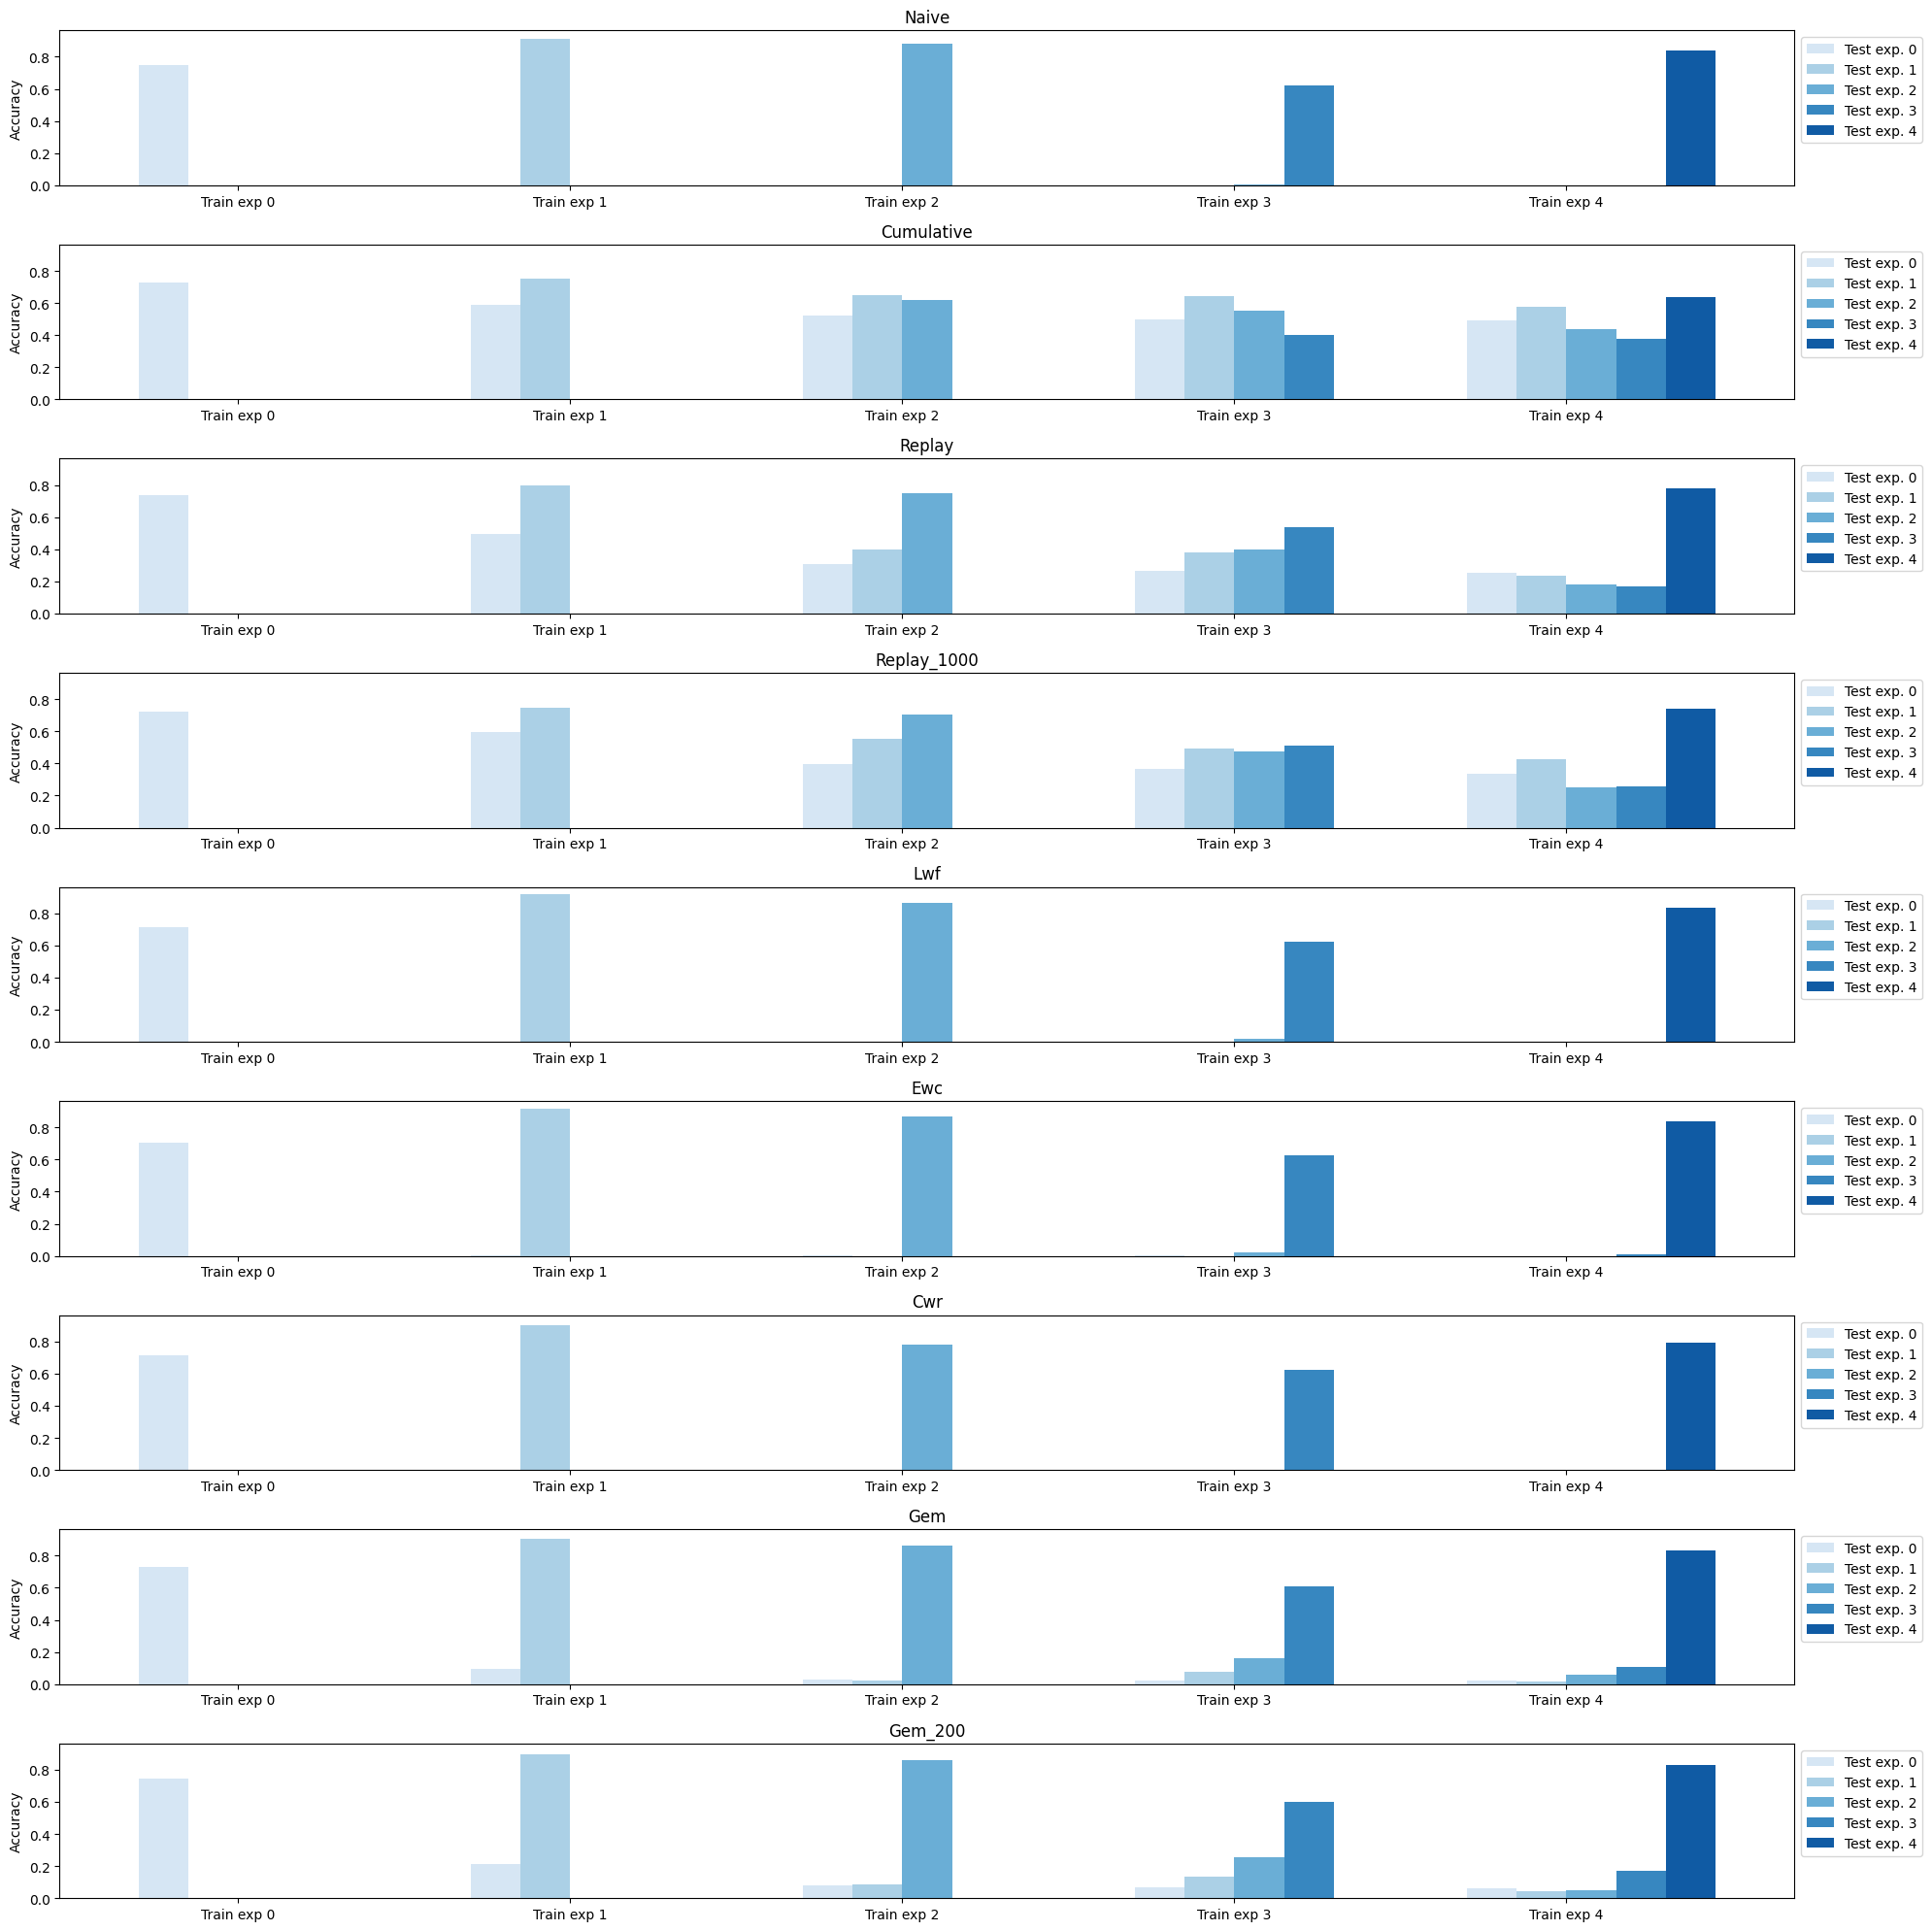

In [ ]:
fontsize=10
plt.rcParams.update({'font.size': fontsize})
fig, ax = plt.subplots(figsize=(2.5*len(strategies),20), nrows=len(strategies), ncols=1, sharey=True)
for i, strategy in enumerate(strategies):
  plot_strategy_accs(strategy, perf, ax[i])
plt.tight_layout()

It's easy to see that, with respect to the previous scenario, strategies have lower accuracies and higher forgetting. We do not know the experience associated with the data points during the inference phase. We do not have task labels. We cannot use multiple heads.

## Accuracy Trend on the experiences seen so far

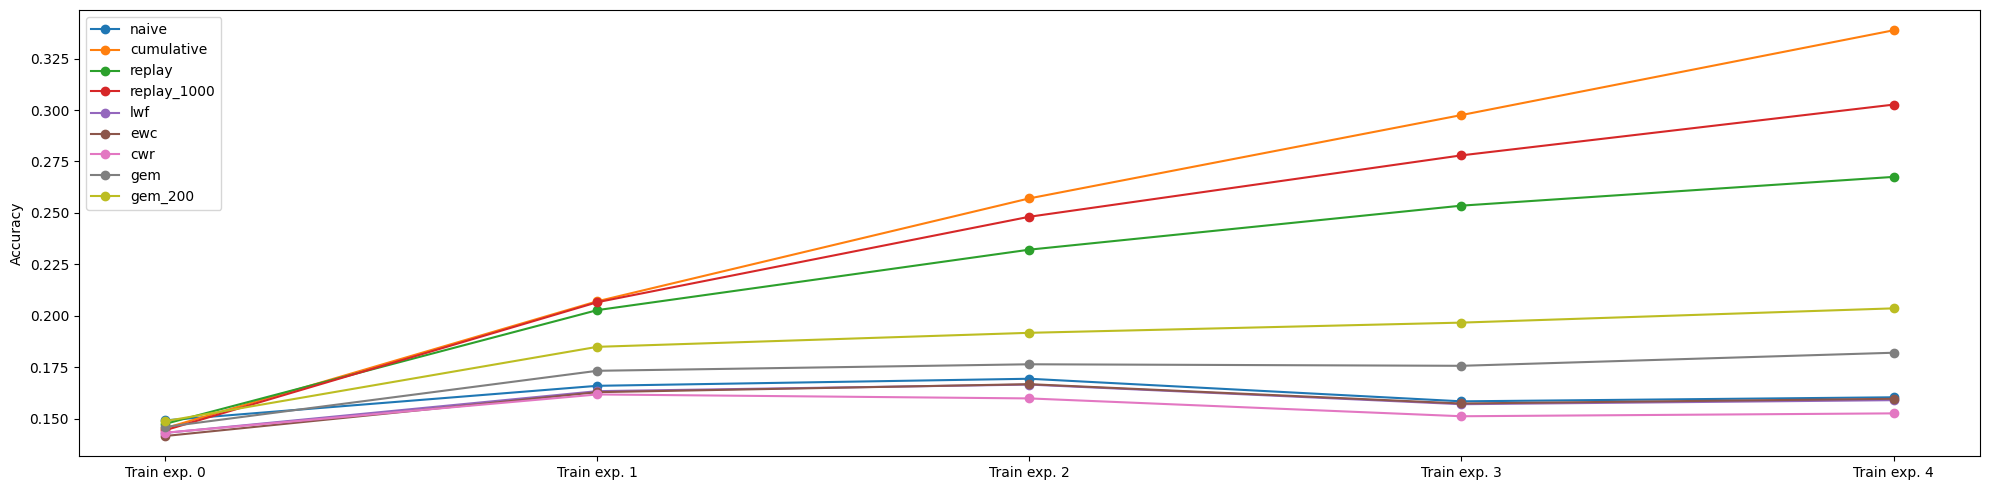

In [ ]:
fig, ax = plt.subplots(figsize=(20,5), nrows=1, ncols=1)
for strategy in perf:
  accs = [np.mean(perf[strategy]["accuracies"][:i+1]) for i in range(len(perf[strategy]["accuracies"]))]
  ax.plot(accs, label=strategy, marker="o")
ax.set_xticks(ticks=np.arange(len(accs)), labels=[f"Train exp. {i}" for i in range(N_EXP)])
ax.set_ylabel("Accuracy")
ax.legend()
plt.tight_layout()

*   Cumulative is again the best strategy (it is usually used as the upper bound of the strategies).
*   Excluding Cumulative, Replay is the best strategy. Increasing the buffer size has a high impact on the performance.
*   The remaining strategies are not able to achieve good performance.
*   In most cases, a simple strategy such as Replay outperforms the other strategies. Simple is better :)

## Final accuracy and Average Accuracy Over Time

In [ ]:
import pandas as pd

Average Accuracy Over Time

In [ ]:
df = pd.DataFrame([[strategy, perf[strategy]["a_metric"]] for strategy in strategies], columns=["Strategy", "a_metric"])
df.sort_values("a_metric", ascending=False)

,Strategy,a_metric
1,cumulative,0.564600
3,replay_1000,0.504367
2,replay,0.445800
8,gem_200,0.339267
7,gem,0.303300
0,naive,0.267200
5,ewc,0.265967
4,lwf,0.264867
6,cwr,0.254167


Final Accuracy

In [ ]:
df = pd.DataFrame([[strategy, perf[strategy]["average_accuracy"]] for strategy in strategies], columns=["Strategy", "Acc"])
df.sort_values("Acc", ascending=False)

,Strategy,Acc
1,cumulative,0.5036
3,replay_1000,0.4013
2,replay,0.3234
8,gem_200,0.2313
7,gem,0.2074
5,ewc,0.1687
0,naive,0.1682
4,lwf,0.1668
6,cwr,0.1581


The previous findings are summarized in these two tables. Again, we can see that the performance are lower than Task Incremental Learning.

## Backward Transfer

In [ ]:
def plot_strategy_bwts(strategy, perf, ax):
  train_exp = [f"Train exp {i}" for i in range(N_EXP)]
  accs = np.array(perf[strategy]["bwt_exp"])
  values = {f'Test exp. {i}': accs[:,i] for i in range(N_EXP-1)}

  cmap = plt.cm.Blues
  x = np.arange(len(train_exp))  # the label locations
  width = 0.15  # the width of the bars
  multiplier = 0

  i = 0
  for attribute, measurement in values.items():
      color = cmap((i+1)*(1/(len(values)+1)))
      offset = width * multiplier
      rects = ax.bar(x + offset, measurement, width, label=attribute, color=color)
      multiplier += 1
      i += 1
  ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], "k--", color="grey", linewidth=1)

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Backward Transfer')
  ax.set_xticks(x + 1.5*width, train_exp)
  ax.set_yticks([0], minor=True)
  ax.legend(bbox_to_anchor=(1,1), loc="upper left")
  ax.set_title(strategy.capitalize())

<ipython-input-29-4f0259a6c579>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], "k--", color="grey", linewidth=1)


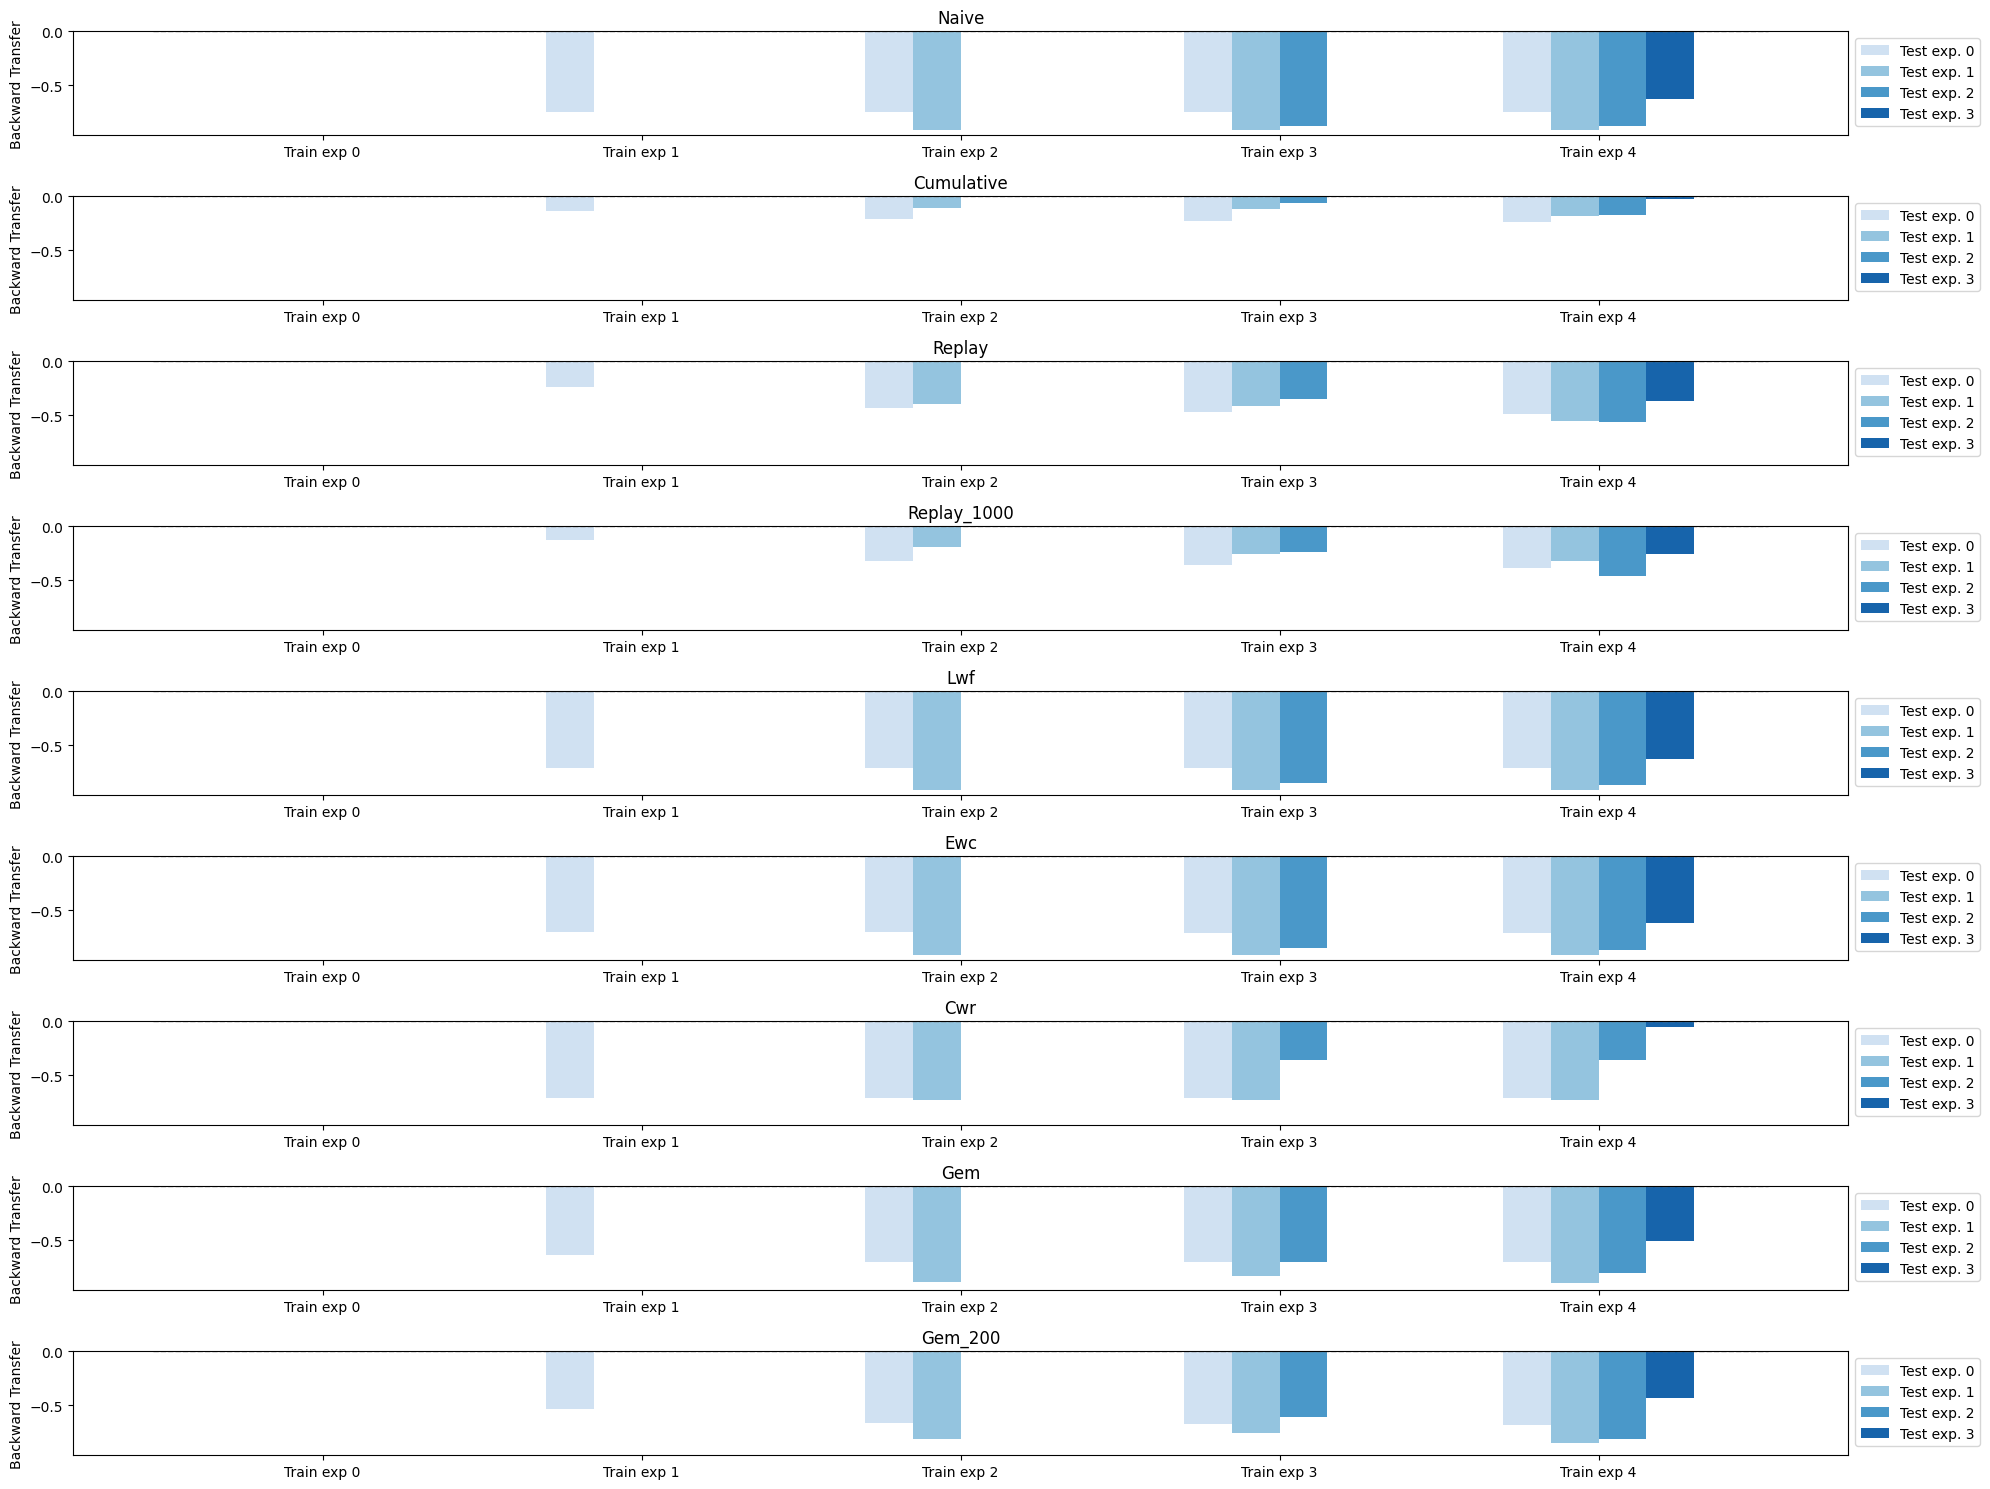

In [ ]:
fig, ax = plt.subplots(figsize=(20,15), nrows=len(strategies), ncols=1, sharey=True)
for i, strategy in enumerate(strategies):
  plot_strategy_bwts(strategy, perf, ax[i])
plt.tight_layout()

Replay is the only strategy that has a lower positive backward transfer in some cases.
Without PNN (which freezes the weights associated with the old tasks) and multiple heads, we do not have strategies with 0 bwt.

In [ ]:
df = pd.DataFrame([[strategy, perf[strategy]["bwt"][-1]] for strategy in strategies], columns=["Strategy", "bwt"])
df.sort_values("bwt", ascending=False)

,Strategy,bwt
1,cumulative,-0.154000
3,replay_1000,-0.354500
6,cwr,-0.463375
2,replay,-0.494250
8,gem_200,-0.693500
7,gem,-0.726375
5,ewc,-0.777250
4,lwf,-0.780000
0,naive,-0.790875


All the strategies suffer from catastrophic forgetting. Increasing the size of Replay's buffer reduces catastrophic forgetting.

## Forward Transfer

In [ ]:
def plot_strategy_ftws(strategy, perf, ax):

  x = [f"Train exp {i}" for i in range(N_EXP-1)]
  values = perf[strategy]["fwt_exp"]

  cmap = plt.cm.Blues

  ax.bar(x, values)
  ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], "k--", color="grey", linewidth=1)

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Forward Transfer')
  ax.set_title(strategy.capitalize())

<ipython-input-34-03136a9e87f5>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], "k--", color="grey", linewidth=1)


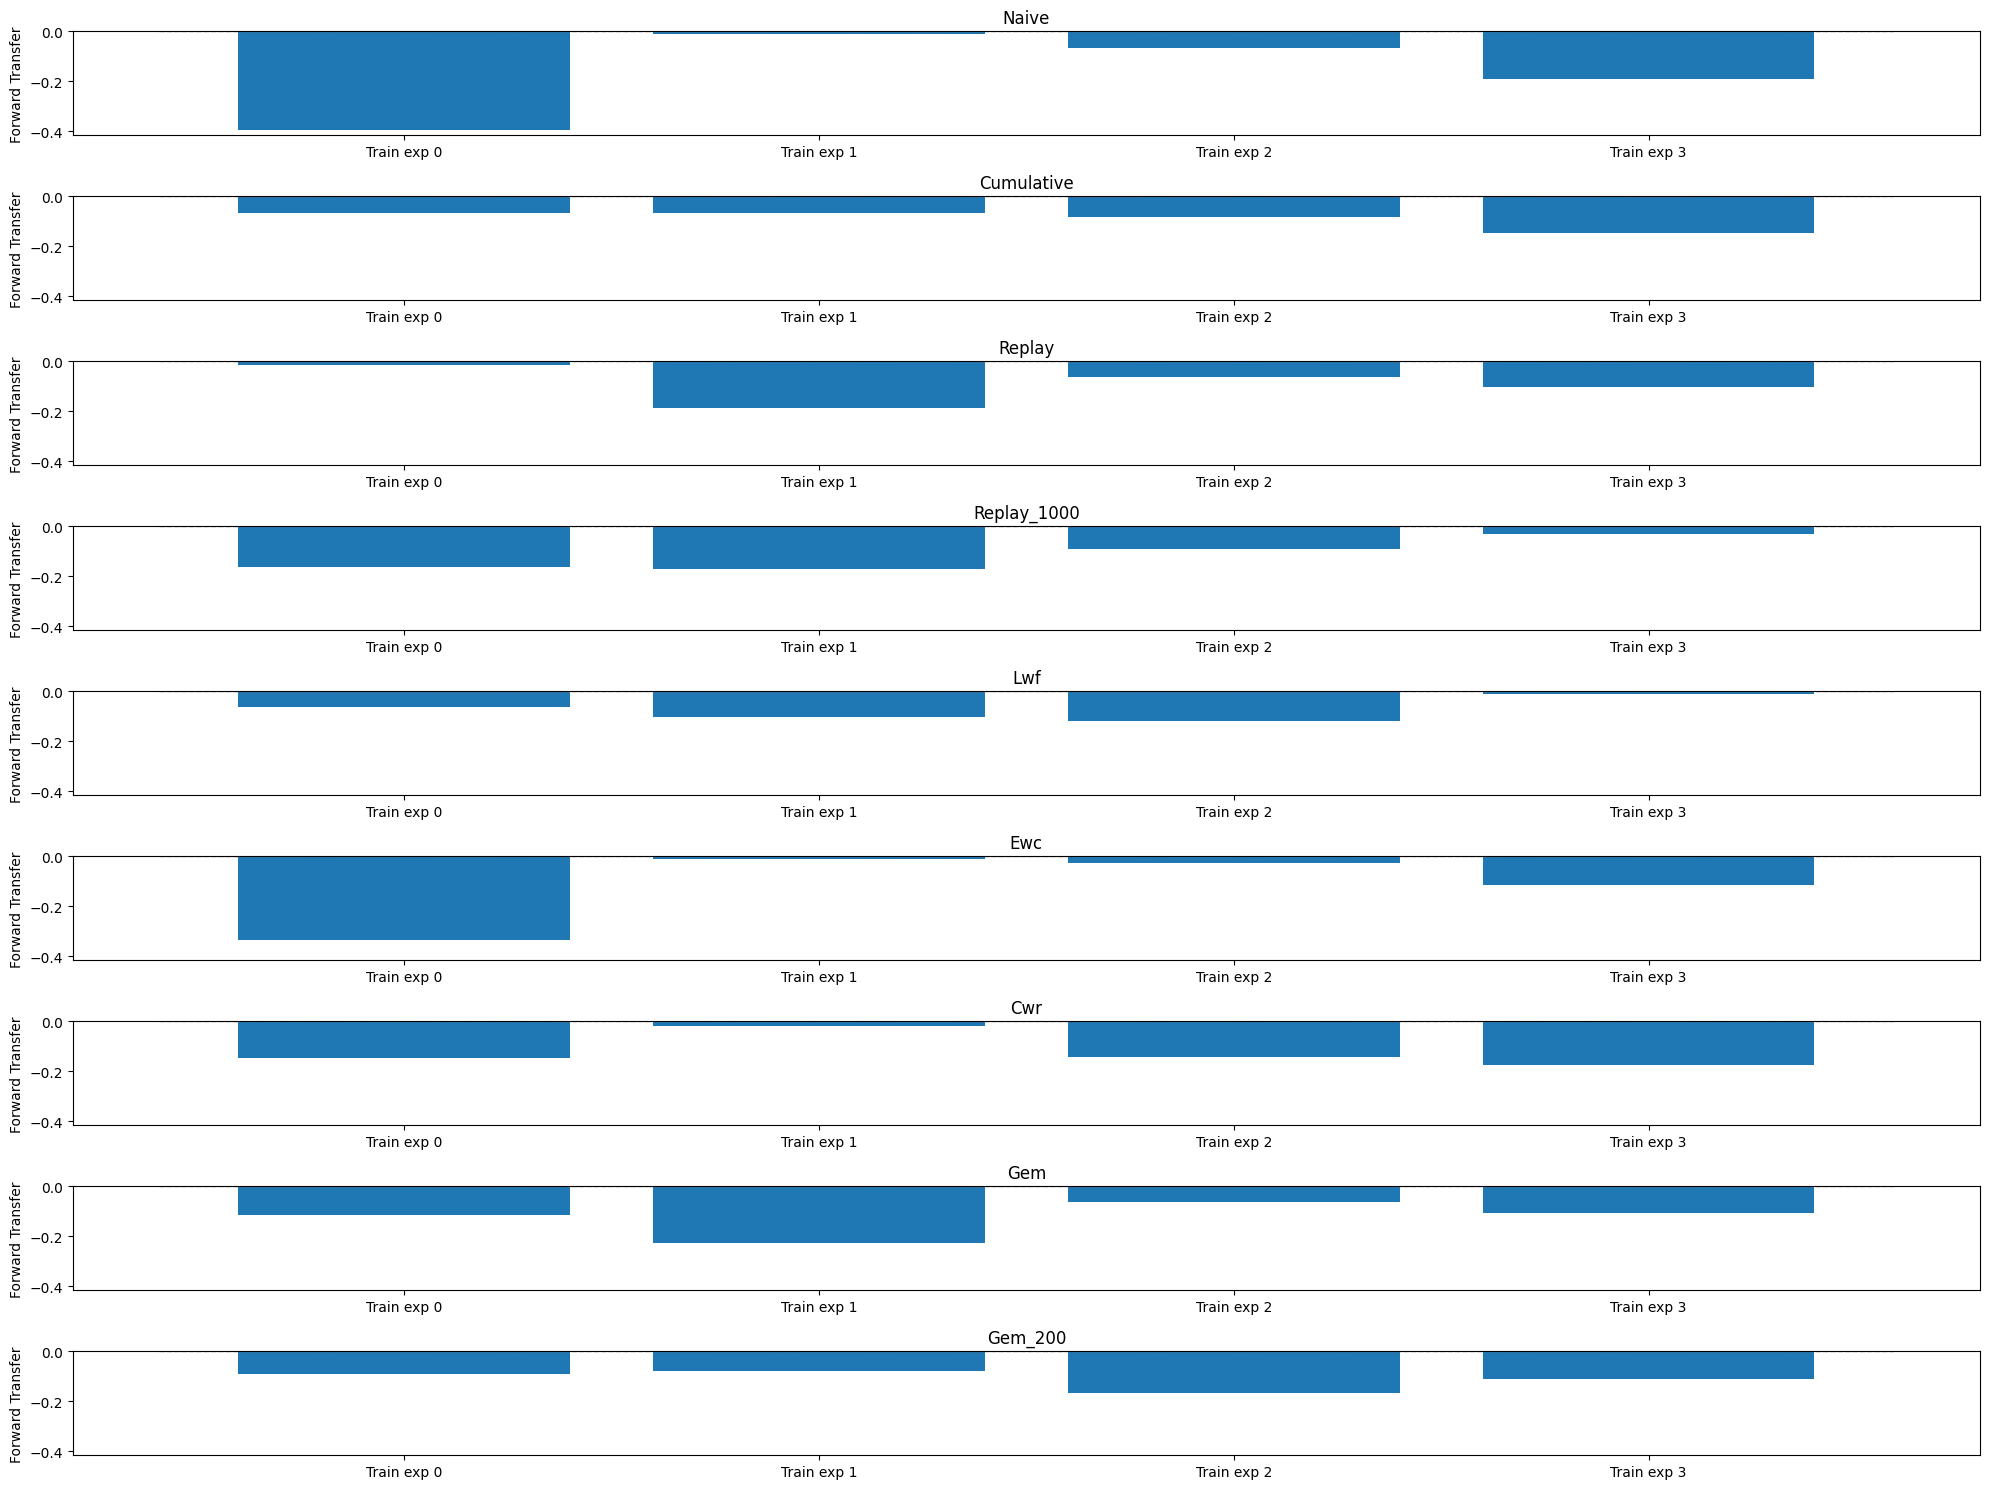

In [ ]:
fig, ax = plt.subplots(figsize=(20,15), nrows=len(strategies), ncols=1, sharey=True)
for i, strategy in enumerate(strategies):
  plot_strategy_ftws(strategy, perf, ax[i])
plt.tight_layout()

In [ ]:
df = pd.DataFrame([[strategy, perf[strategy]["fwt"]] for strategy in strategies], columns=["Strategy", "fwt"])
df.sort_values("fwt", ascending=False)

,Strategy,fwt
4,lwf,-0.074250
1,cumulative,-0.090750
2,replay,-0.092125
8,gem_200,-0.110875
3,replay_1000,-0.113500
6,cwr,-0.120750
5,ewc,-0.121625
7,gem,-0.127625
0,naive,-0.166000


No strategy can improve the learning on the next experience.

## Memory

In [ ]:
df = pd.DataFrame([[strategy, perf[strategy]["ram"][-1]] for strategy in strategies], columns=["Strategy", "Max RAM Usage"])
df.sort_values("Max RAM Usage", ascending=True)

,Strategy,Max RAM Usage
0,naive,1490.847656
1,cumulative,1497.367188
2,replay,1497.636719
3,replay_1000,1497.917969
5,ewc,1501.597656
4,lwf,1595.738281
6,cwr,1618.789062
7,gem,1753.593750
8,gem_200,1756.582031


*   Naive is the simplest strategy and has a lower maximum RAM usage.
*   GEM is a complex strategy that mixes Replay and Regularization. It requires more RAM.
*   The increase in the buffer size does not significantly impact the maximum RAM usage.

## Time

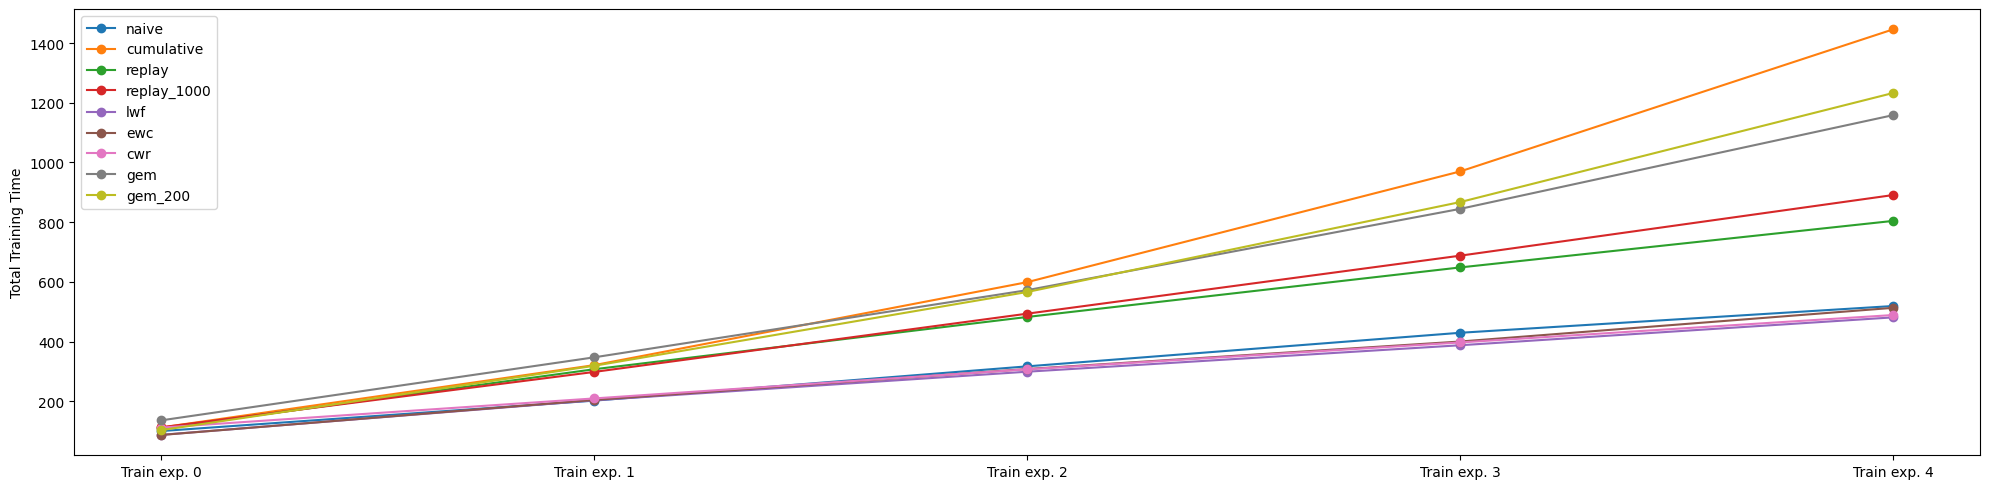

In [ ]:
fig, ax = plt.subplots(figsize=(20,5), nrows=1, ncols=1, sharey=True)
for strategy in perf:
  ax.plot(perf[strategy]["time_cum"], label=strategy, marker="o")
ax.set_xticks(ticks=np.arange(N_EXP), labels=[f"Train exp. {i}" for i in range(N_EXP)])
ax.set_ylabel("Total Training Time")
ax.legend()
plt.tight_layout()

In [ ]:
df = pd.DataFrame([[strategy, perf[strategy]["time_cum"][-1]] for strategy in strategies], columns=["Strategy", "Total Training Time"])
df.sort_values("Total Training Time", ascending=True)

,Strategy,Total Training Time
4,lwf,481.066437
6,cwr,488.895590
5,ewc,513.042527
0,naive,519.101215
2,replay,804.316417
3,replay_1000,890.985815
7,gem,1158.735965
8,gem_200,1232.983108
1,cumulative,1446.235167


*   Cumulative requires more time to be trained since it has all the data from the previous experiences' training sets.
*   GEM is a complex strategy that mixes Replay and Regularization. This results in a slow training.
*   Replay is slower than regularization strategies, CWR, and Naive.
*   The increase in the buffer size causes an increase in the training time.



### Final considerations

*   Performance is lower than Task Incremental Learning. The classes appear over time and are not available from the beginning. During the inference phase, we do not know which experiences data points belong to. We cannot isolate the parameters of each experience as for Multi-Head models in Task Incremental.
*   Cumulative is usually used as the upper bound of classification performance. It is the best-performing strategy.
*   Cumulative is not applicable in the real world since it fine-tunes the model using all the previous experiences and the current one.
*   Replay is the best-performing strategy, excluding Cumulative. It can outperform a more complex approach like GEM. However, it requires a buffer to store previous data points.
*   Augmenting the buffer size increases the classification performance but requires more time.
*   The other strategies do not perform well. In Class Incremental Learning, replay strategies usually perform well.